# Getting Started

In this tutorial, you'll learn the basics of using the `tuesday` package.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as un

%matplotlib inline

import powerbox as pb

from tuesday.core import calculate_ps_coeval, calculate_ps_lc, plot_power_spectrum, SphericalPS

## Calculate the PS from a coeval box

Let's make a test coeval box using `powerbox`.

In [2]:
delta_x = pb.PowerBox(
    N=32,  # Number of grid-points in the box
    dim=3,  # 2D box
    pk=lambda k: 0.1 * k**-2.0,  # The power-spectrum
    boxlength=200.0,  # Size of the box (sets the units of k in pk)
    seed=1010,  # Set a seed to ensure the box looks the same every time (optional)
).delta_x()

Let's calculate the PS on this box:

In [3]:
ps = calculate_ps_coeval(
    delta_x * un.dimensionless_unscaled,
    box_length=200.0 * un.Mpc,
    calc_2d=True,
    calc_1d=True,
    delta=False,
)

/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/powerbox/tools.py:261: FutureWarning: In the future, bins will be generated by default up to the smallest length over any dimension, instead of the largest magnitude for the box.Set bins_upto_boxlen to silence this warning.
  bins = _getbins(bins, coord_mags, log_bins, bins_upto_boxlen=bins_upto_boxlen)
/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/powerbox/tools.py:287: RuntimeWarning: invalid value encountered in divide
  np.bincount(
/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/powerbox/tools.py:732: UserWarning: One or more radial bins had no cells within it.
  return angular_average(


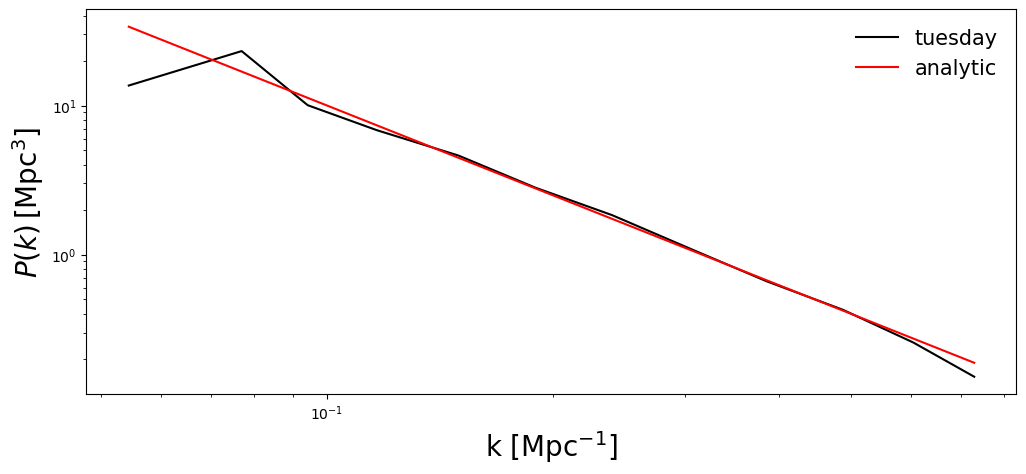

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax = plot_power_spectrum(
    ps["ps_1d"],
    fontsize=20,
    ax=ax,
    color="k",
    label="tuesday",
    logx=True,
    logy=True,
)
ps2 = SphericalPS(ps = 0.1 * ps["ps_1d"].k.value ** -2.0 * ps["ps_1d"].ps.unit,
                  k = ps["ps_1d"].k)
ax = plot_power_spectrum(
    ps2,
    fontsize=20,
    ax=ax,
    color="r",
    label="analytic",
    legend_kwargs={"loc": "upper right", "frameon": False, "fontsize": 15},
    logx=True,
    logy=True,
)

We can also plot the 2D power spectrum:

/home/dani/miniconda3/envs/21cmFAST/lib/python3.11/site-packages/astropy/units/quantity.py:1891: RuntimeWarning: Mean of empty slice
  return super().__array_function__(function, types, args, kwargs)


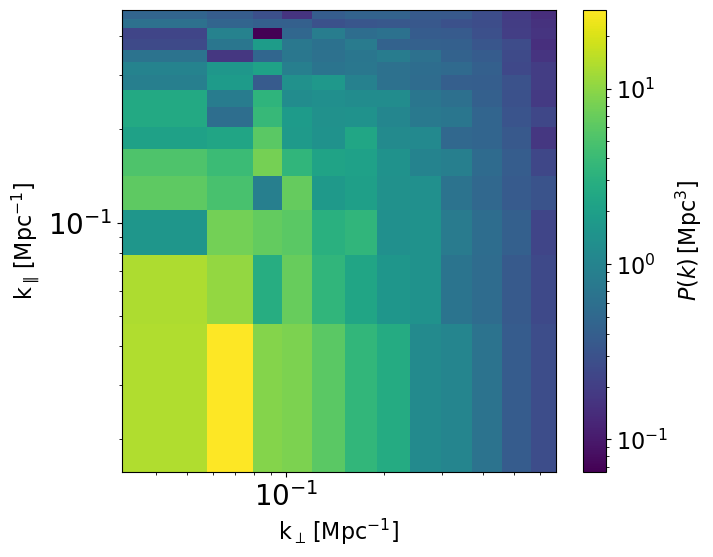

In [5]:
ax = plot_power_spectrum(
    ps["ps_2d"],
    logx=True,
    logy=True,
    logc=True,
)

## Calculate the PS from a lightcone

We start by making a test lightcone by stitching a few coeval boxes from above:

In [6]:
lc = delta_x
for i in range(60):
    delta_x = pb.PowerBox(
        N=32,  # Number of grid-points in the box
        dim=3,  # 2D box
        pk=lambda k: 0.1 * k**-2.0,  # The power-spectrum
        boxlength=200.0,  # Size of the box (sets the units of k in pk)
        seed=np.random.randint(0,10000, 1),  # Set a seed to ensure the box looks the same every time (optional)
    ).delta_x()
    lc = np.concatenate((lc, delta_x), axis=-1)
print(lc.shape)

(32, 32, 1952)


Let's pretend this lightcone spans redshifts 6 to 35:

In [7]:
lc_redshifts = np.linspace(6,35,lc.shape[-1])

In [8]:
ps = calculate_ps_lc(
    lc * un.dimensionless_unscaled,
    box_length=200.0 * un.Mpc,
    lc_redshifts=lc_redshifts,
    ps_redshifts=[6,7,8,35],
    calc_2d=True,
    calc_1d=True,
    delta=None,
)

Now the output is a dict containing `ps_1d` and `ps_2d` with `SphericalPS` and `CylindricalPS` instances, respectively. Each of these PS can be accessed via the key corresponding to the chunk redshift:

In [9]:
ps.keys()

dict_keys(['ps_1d', 'ps_2d'])

In [10]:
ps['ps_1d'].keys()

dict_keys(['z = 6.24', 'z = 7.0', 'z = 8.01', 'z = 34.88'])

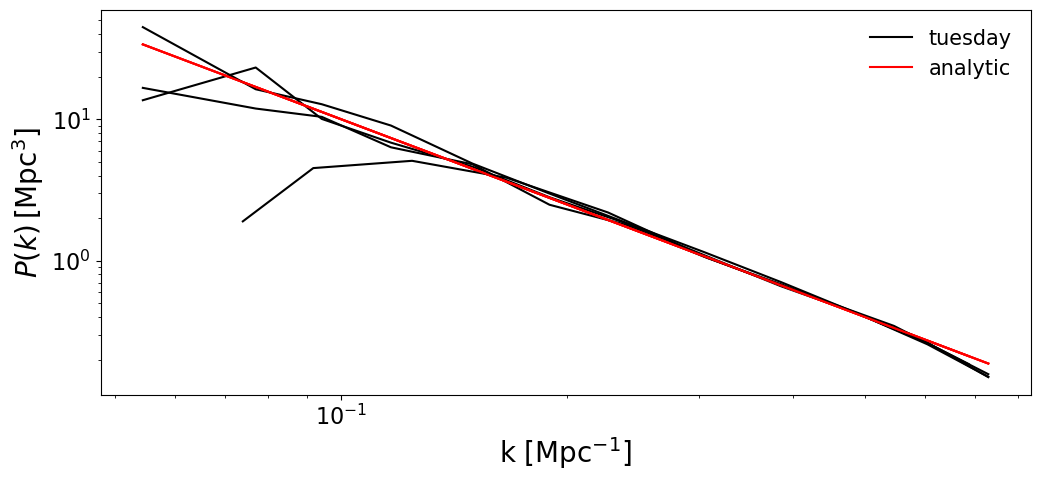

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for key in ps['ps_1d'].keys():
    ax = plot_power_spectrum(
        ps['ps_1d'][key],
        fontsize=20,
        ax=ax,
        color="k",
        label="tuesday" if key == list(ps['ps_1d'].keys())[-1] else None,
        logx=True,
        logy=True,
    )
    ps2 = SphericalPS(ps = 0.1 * ps["ps_1d"][key].k.value ** -2.0 * ps["ps_1d"][key].ps.unit,
                  k = ps["ps_1d"][key].k)
    ax = plot_power_spectrum(
        ps2,
        fontsize=20,
        ax=ax,
        color="r",
        label="analytic" if key == list(ps['ps_1d'].keys())[-1] else None,
        legend_kwargs={"loc": "upper right", "frameon": False, "fontsize": 15} if key == list(ps['ps_1d'].keys())[-1] else None,
        logx=True,
        logy=True,
    )

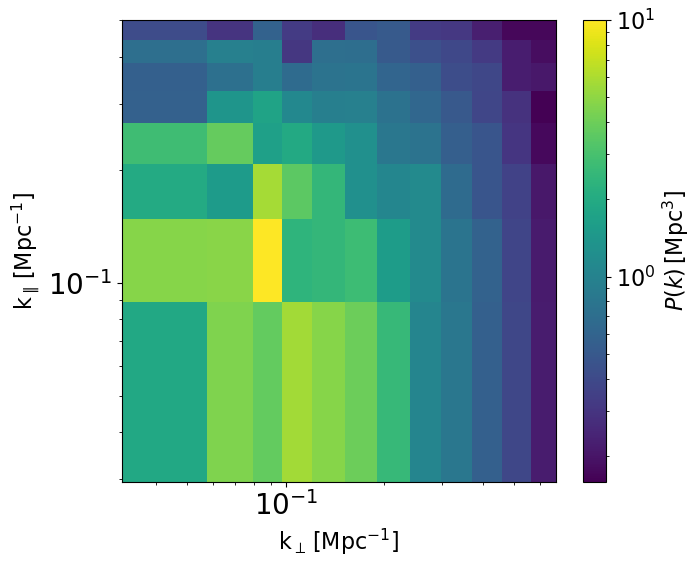

In [12]:
ax = plot_power_spectrum(ps['ps_2d'][key],
    logx=True,
    logy=True,
    logc=True,
)